<h3>Setup</h3>

In [2]:
import sys
sys.path.append('../src')

In [3]:
# pip install s3fs xarray geopandas pandas shapely datetime zarr dask rasterio rioxarray scipy rasterstats tqdm matplotlib
import datetime, zarr, dask, rasterio as rio, rioxarray as rxr, pandas as pd, rasterstats, tqdm, pathlib, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal, truncnorm
import plotnine as pn
import os
import subprocess
import importlib


In [2]:
import met

In [ ]:
#Download data from AWS
#1. Install AWS CLI - https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html
#2. In terminal inside docker type - aws configure
#3. Add key provided by admin and set region to us-west-2 and output format to json

#HUC 150602 S3 URL
s3_url = "s3://importance-sampling-sst/huc_150602/"
local_dir = "/workspaces/Importance-Sampling-for-SST/data/0_source/huc_150602"
os.makedirs(local_dir)
subprocess.run(["aws","s3","cp",s3_url,local_dir,"--recursive"], check = True)

<h3>1. Generate events (only for new watersheds)</h3>

In [4]:
from met import AORCEventGenerator, EventCatalogProcessor

In [28]:
import met

<h5>1.1. Create .nc files </h5>

In [ ]:
# 72-hour, 10 events per year, declustered by 5 days. using domain geojson
generator = AORCEventGenerator(
    geojson_path="/workspaces/Importance-Sampling-for-SST/data/0_source/test/domain.geojson",
    start_date=datetime.datetime(2012, 1, 1),
    end_date=datetime.datetime(2012, 12, 31),
    duration_hours=72,
    threshold_mm=63.5,
    min_separation_hours=120,
    max_events_per_year=10,
    output_dir="/workspaces/Importance-Sampling-for-SST/data/1_interim/events"
)

#Run
generator.load_and_clip_dataset()
generator.decluster_events()
generator.save_events()

#or
#generator.run_all()

<h5>1.2. Aggregate Precip to .tif </h5>

In [5]:
# 1.2. Convert .nc files to aggregated .tif total precip files and a pickle file with tif location and storm centroid
catalog_processor = EventCatalogProcessor(
    folder_storms="/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/nc_files",
    nc_data_name="band_data",
    output_dir="/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/catalog",
    centroid_backend="xarray"
)

catalog_processor.run()

Opening NetCDF file: /workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/nc_files/19790205_T163.nc
Summing 'band_data' over 'time'...
Saving GeoTIFF to: /workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/catalog/tifs/19790205_T163.tif
Closed NetCDF.
Opening NetCDF file: /workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/nc_files/19790211_T411.nc
Summing 'band_data' over 'time'...
Saving GeoTIFF to: /workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/catalog/tifs/19790211_T411.tif
Closed NetCDF.
Opening NetCDF file: /workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/nc_files/19790303_T304.nc
Summing 'band_data' over 'time'...
Saving GeoTIFF to: /workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/catalog/tifs/19790303_T304.tif
Closed NetCDF.
Opening NetCDF file: /workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/nc_files/19791018_T229.nc
Summing 'band_data' over 'time'...
Saving GeoTIFF to: /workspaces/Impor

In [ ]:
# View catalog
catalog_path = "/workspaces/Importance-Sampling-for-SST/data/1_interim/huc_150602_catalog/catalog.pkl"
df = pd.read_pickle(catalog_path)
df.head()

,name,path,x,y
0,event_100_19901222T04,/workspaces/Importance-Sampling-for-SST/data/1...,-110.253108,33.358258
1,event_100_20001107T04,/workspaces/Importance-Sampling-for-SST/data/1...,-109.922917,32.940807
2,event_100_20101231T23,/workspaces/Importance-Sampling-for-SST/data/1...,-114.126627,34.254994
3,event_100_20211231T23,/workspaces/Importance-Sampling-for-SST/data/1...,-110.398731,33.973303
4,event_101_20110219T22,/workspaces/Importance-Sampling-for-SST/data/1...,-111.372908,35.351411


<h3>2. Sampling and Transposition</h3>

In [ ]:
#Download folder from AWS Bucket
#s3://importance-sampling-sst/huc_150602/

<h5> 2.1 Preprocess data </h5>

In [26]:
#import transpose
#importlib.reload(transpose)
from utils import raster_zonal_mean, match_crs_to_raster, get_sp_stats, truncnorm_params
from transpose import transpose_gdf, transpose_storm, compute_depths, sample_storms, sample_storms_lhs, sample_storms_lhs_equally

In [ ]:
#Locate data
path_sp_watershed = "/workspaces/Importance-Sampling-for-SST/data/0_source/huc_150602/watershed_150602_wgs.geojson"
path_sp_daws

path_storm = pathlib.Path('/workspaces/Importance-Sampling-for-SST/data/1_interim/huc_150602_catalog')
df_storms = pd.read_pickle(path_storm/'catalog.pkl')

In [5]:
#Load shapefiles and match projection with rasters
sp_watershed = gpd.read_file(path_sp_watershed)
sp_watershed = match_crs_to_raster(sp_watershed, df_storms['path'].iloc[0])

sp_domain = gpd.read_file(path_sp_domain)
sp_domain = match_crs_to_raster(sp_domain, df_storms['path'].iloc[0])

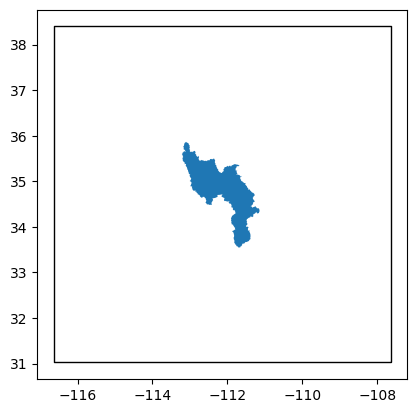

In [6]:
sp_watershed.plot()
sp_domain.plot(ax=plt.gca(),facecolor="none")
plt.show()

In [7]:
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)
print(v_watershed_stats, v_domain_stats)

minx         -113.215439
miny           33.540998
maxx         -111.137206
maxy           35.866528
x            -112.132596
y              34.793973
range_x         2.078233
range_y         2.325530
area_km2    25520.445362
Name: 0, dtype: float64 minx           -116.624162
miny             31.024392
maxx           -107.641009
maxy             38.398801
x              -112.132585
y                34.711596
range_x           8.983153
range_y           7.374410
area_km2    1000000.000000
Name: 0, dtype: float64


/workspaces/Importance-Sampling-for-SST/notebooks/../src/utils/transposeutils.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/workspaces/Importance-Sampling-for-SST/notebooks/../src/utils/transposeutils.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



<h5>2.2. Sample </h5>

In [66]:
dist_x = truncnorm(**truncnorm_params(v_watershed_stats.x, v_watershed_stats.range_x*1, v_domain_stats.minx, v_domain_stats.maxx))
dist_y = truncnorm(**truncnorm_params(v_watershed_stats.y, v_watershed_stats.range_y*1, v_domain_stats.miny, v_domain_stats.maxy))

In [ ]:
n_sim_mc_0 = 100000
n_sim_is_1 = 10000
df_storm_sample_mc_0 = sample_storms(df_storms, v_domain_stats, dist_x=None, dist_y=None, num_simulations=n_sim_mc_0)
df_storm_sample_mc_1 = sample_storms(df_storms, v_domain_stats, dist_x=None, dist_y=None, num_simulations=n_sim_is_1)
df_storm_sample_is_1 = sample_storms(df_storms, v_domain_stats, dist_x, dist_y, num_simulations=n_sim_is_1)

<h5>2.3 Compute Depths </h5>

In [43]:
df_depths_mc_0 = compute_depths(df_storm_sample_mc_0, sp_watershed)
df_depths_mc_0.to_pickle("/workspaces/Importance-Sampling-for-SST/data/1_interim/huc_150602/df_depths_mc_0.pkl")
df_depths_mc_0 = pd.read_pickle("/workspaces/Importance-Sampling-for-SST/data/1_interim/huc_150602/df_depths_mc_0.pkl")

  0%|          | 100/100000 [00:16<1:27:25, 19.05it/s]

In [45]:
df_depths_mc_1 = compute_depths(df_storm_sample_mc_1, sp_watershed)


100%|██████████| 10000/10000 [09:20<00:00, 17.83it/s]


In [46]:
df_depths_is_1 = compute_depths(df_storm_sample_is_1, sp_watershed)

100%|██████████| 10000/10000 [09:23<00:00, 17.76it/s]


<h3>3. Evaluate</h3>

In [27]:
from evaluation import print_sim_stats, get_df_freq_curve

In [48]:
print_sim_stats(df_depths_mc_0)
print_sim_stats(df_depths_mc_1)
print_sim_stats(df_depths_is_1)

Intersected: 88535 out of 100000 (88.53%)
Total Weights: Total  1.00, Intersected: 0.89
Depth: 2.32 ± 0.02
Depth Estimate: 2.32 ± 0.02
Intersected: 8841 out of 10000 (88.41%)
Total Weights: Total  1.00, Intersected: 0.88
Depth: 2.31 ± 0.05
Depth Estimate: 2.31 ± 0.05
Intersected: 9265 out of 10000 (92.65%)
Total Weights: Total  1.00, Intersected: 0.88
Depth: 2.32 ± 0.05
Depth Estimate: 2.32 ± 0.06


In [49]:
df_freq_curve_mc_0 = get_df_freq_curve(df_depths_mc_0.depth, df_depths_mc_0.prob)
df_freq_curve_mc_1 = get_df_freq_curve(df_depths_mc_1.depth, df_depths_mc_1.prob)
df_freq_curve_is_1 = get_df_freq_curve(df_depths_is_1.depth, df_depths_is_1.prob)

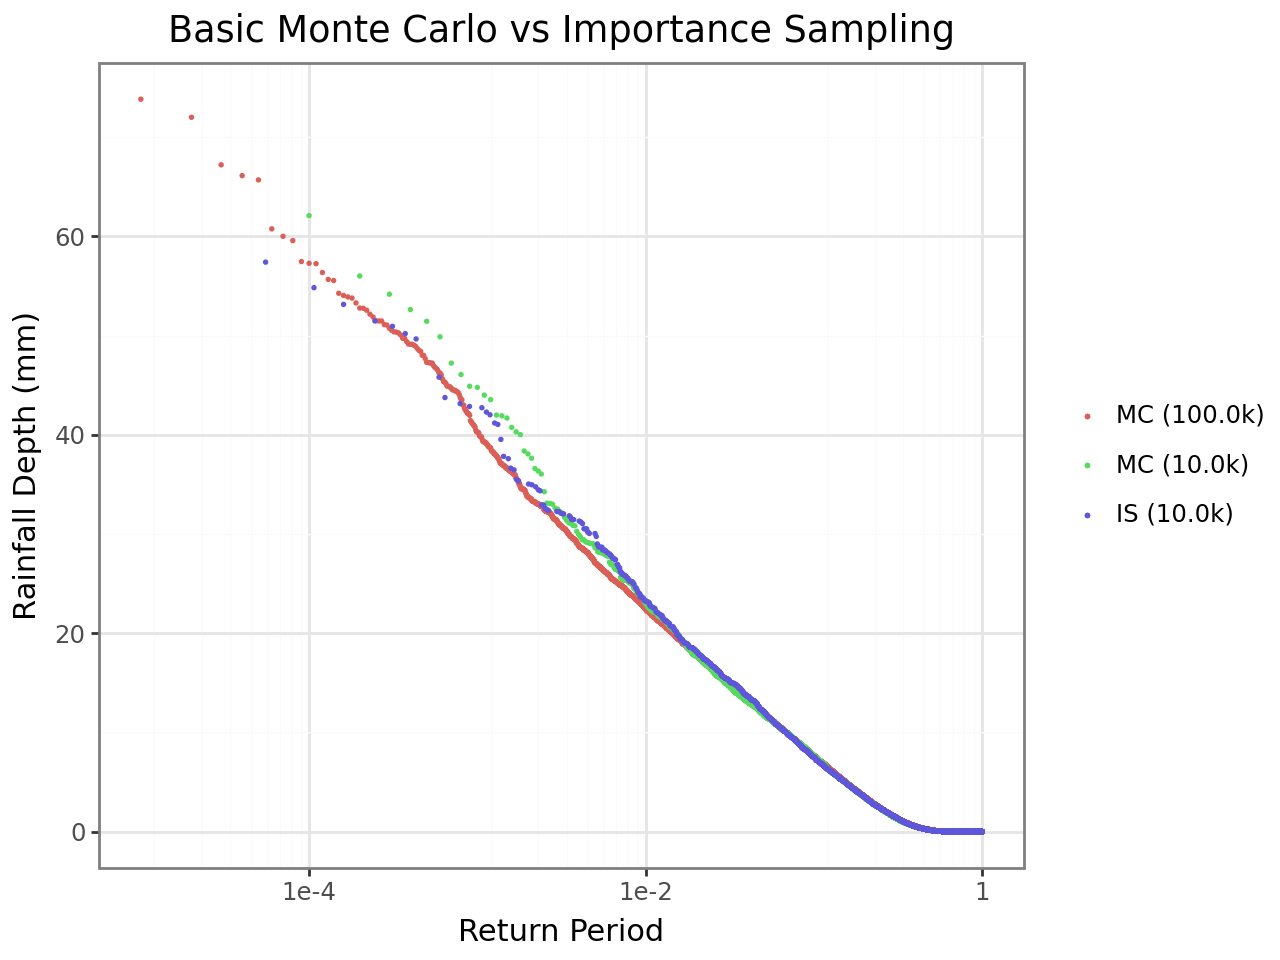

In [50]:
(pn.ggplot(mapping=pn.aes(x='prob_exceed', y='depth'))
        + pn.geom_point(data=df_freq_curve_mc_0, mapping=pn.aes(color=f'"MC ({n_sim_mc_0/1000}k)"'), size=0.1)
        + pn.geom_point(data=df_freq_curve_mc_1, mapping=pn.aes(color=f'"MC ({n_sim_is_1/1000}k)"'), size=0.1)
        + pn.geom_point(data=df_freq_curve_is_1, mapping=pn.aes(color=f'"IS ({n_sim_is_1/1000}k)"'), size=0.1)
        + pn.scale_x_log10()
        + pn.labs(
            x = 'Return Period',
            y = 'Rainfall Depth (mm)',
            title = 'Basic Monte Carlo vs Importance Sampling'
        )
        + pn.theme_bw()
        + pn.theme(
            title = pn.element_text(hjust = 0.5),
            # legend_position = 'bottom',
            legend_title = pn.element_blank(),
            legend_key = pn.element_blank(),
            axis_title_y = pn.element_text(ha = 'left'),
        )
    )

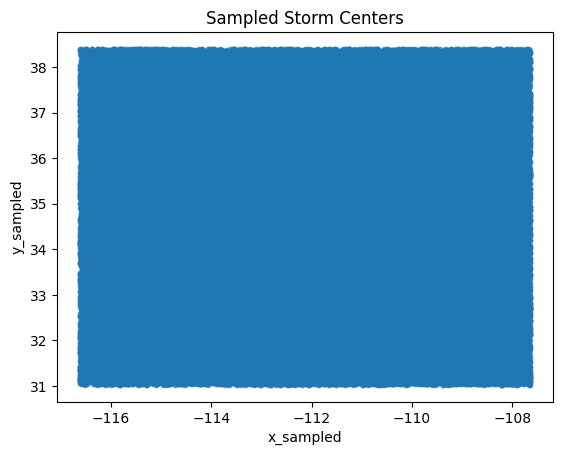

In [54]:
df_depths_mc_0.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6)
plt.title("Sampled Storm Centers")
plt.show()

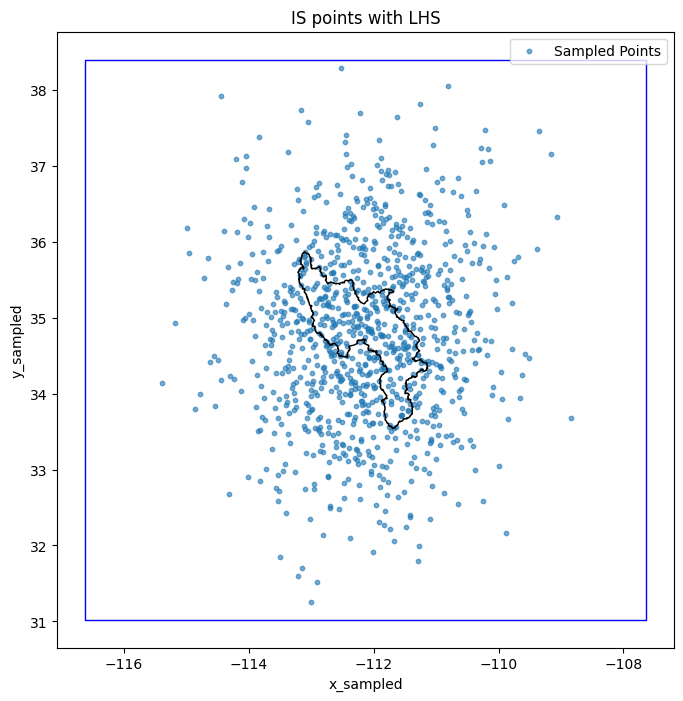

In [68]:
dist_x = truncnorm(**truncnorm_params(v_watershed_stats.x, v_watershed_stats.range_x*0.5, v_domain_stats.minx, v_domain_stats.maxx))
dist_y = truncnorm(**truncnorm_params(v_watershed_stats.y, v_watershed_stats.range_y*0.5, v_domain_stats.miny, v_domain_stats.maxy))
df_storm_sample_is_1 = sample_storms_lhs_equally(df_storms, v_domain_stats, dist_x, dist_y, num_simulations=1000)

fig, ax = plt.subplots(figsize=(8, 8))
df_storm_sample_is_1.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("IS points with LHS")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 5377.55it/s]


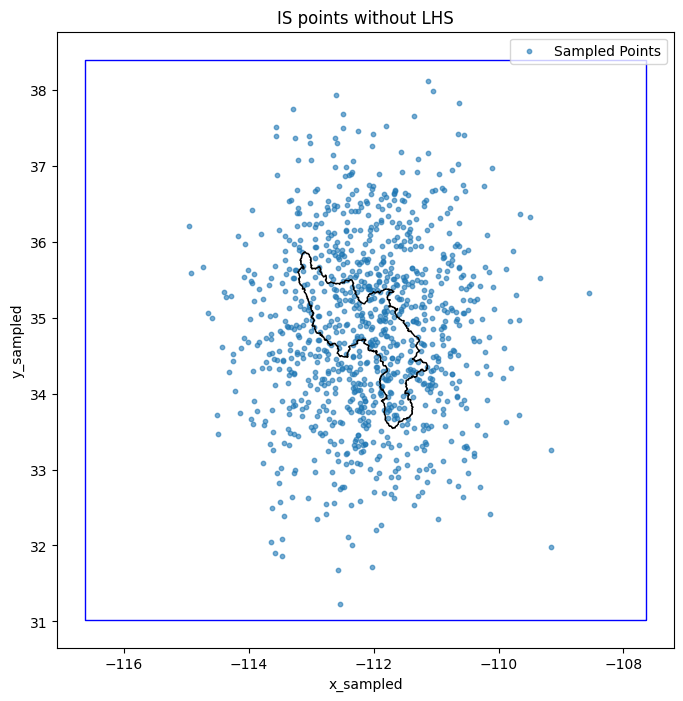

In [78]:
dist_x = truncnorm(**truncnorm_params(v_watershed_stats.x, v_watershed_stats.range_x*0.5, v_domain_stats.minx, v_domain_stats.maxx))
dist_y = truncnorm(**truncnorm_params(v_watershed_stats.y, v_watershed_stats.range_y*0.5, v_domain_stats.miny, v_domain_stats.maxy))
df_storm_sample_is_1 = sample_storms(df_storms, v_domain_stats, dist_x, dist_y, num_simulations=1000)

fig, ax = plt.subplots(figsize=(8, 8))
df_storm_sample_is_1.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("IS points without LHS")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

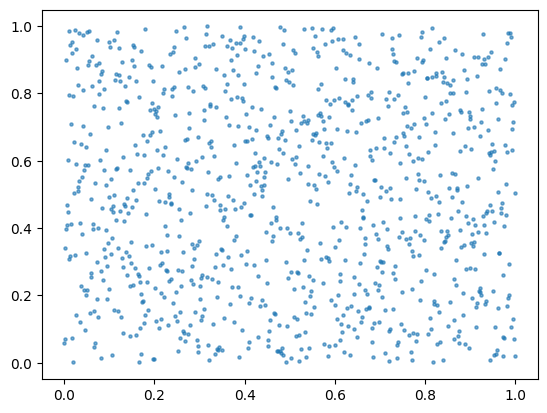

In [77]:
from pyDOE2 import lhs
unit_samples = lhs(2, samples=1000)

plt.scatter(unit_samples[:, 0], unit_samples[:, 1], s=5, alpha=0.6)
plt.show()

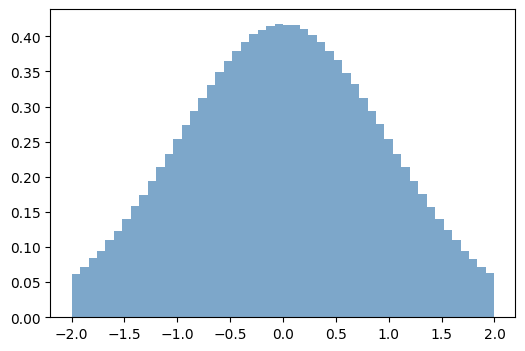

In [82]:
unit_samples = lhs(1, samples=10000)  # in [0, 1]
samples = truncnorm(-2, 2, loc=0, scale=1).ppf(unit_samples) 

plt.figure(figsize=(6, 4))
plt.hist(samples, bins=50, density=True, color='steelblue', alpha=0.7)
plt.show()

In [84]:
import numpy as np

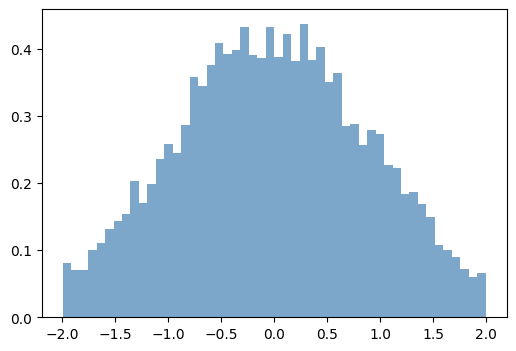

In [85]:
unit_samples = np.random.rand(10000, 1)
samples = truncnorm(-2, 2, loc=0, scale=1).ppf(unit_samples) 

plt.figure(figsize=(6, 4))
plt.hist(samples, bins=50, density=True, color='steelblue', alpha=0.7)
plt.show()